In [65]:
import feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.kde import gaussian_kde
%matplotlib inline

In [2]:
# raw_df = pd.read_csv('data/trip_data.csv',parse_dates=['start_date','end_date'])
# %time raw_df.to_feather('data/raw_data')

In [10]:
raw_df = pd.read_feather('data/raw_data')

In [11]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144015 entries, 0 to 144014
Data columns (total 11 columns):
trip_id              144015 non-null int64
duration             144015 non-null int64
start_date           144015 non-null datetime64[ns]
start_station        144015 non-null object
start_terminal       144015 non-null int64
end_date             144015 non-null datetime64[ns]
end_station          144015 non-null object
end_terminal         144015 non-null int64
bike_#               144015 non-null int64
subscription_type    144015 non-null object
zip_code             137885 non-null object
dtypes: datetime64[ns](2), int64(5), object(4)
memory usage: 12.1+ MB


In [86]:
raw_df.head()

,trip_id,duration,start_date,start_station,start_terminal,end_date,end_station,end_terminal,bike_#,subscription_type,zip_code,month,dayofweek,date,hour,trips
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,8,4,2013-08-29,15,1
1,4607,70,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,95138,8,4,2013-08-29,15,1
2,4130,71,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,97214,8,4,2013-08-29,11,1
3,4251,77,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,95060,8,4,2013-08-29,12,1
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103,8,4,2013-08-29,13,1


In [59]:
def read_trips_and_preprocess(filename):
    # Read in file
    trips = pd.read_feather('data/raw_data')
    start_time = trips['start_date']

    # Get hour, date, dayofweek
    trips['hr'] = start_time.apply(lambda x: x.hour) + 1
    trips['date'] = start_time.apply(lambda x: x.date())    
    trips['dayofweek'] = start_time.apply(lambda x: x.dayofweek + 1) #Monday=1, Sunday=7
    trips['month'] = start_time.apply(lambda x: x.month)
    trips['count'] = 1
    return trips

trips = read_trips_and_preprocess('data/raw_data')

In [73]:
count_on_each_day.describe()

count     184.000000
mean      782.690217
std       294.595020
min        81.000000
25%       504.000000
50%       897.500000
75%      1015.750000
max      1264.000000
Name: count, dtype: float64

In [61]:
trips.groupby('month').count()['count']

month
1     24428
2     19024
8      2102
9     25243
10    29105
11    24219
12    19894
Name: count, dtype: int64

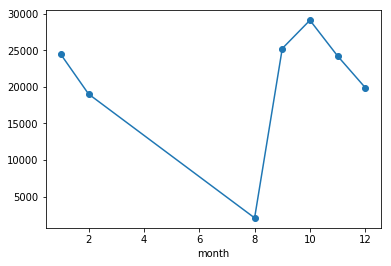

In [62]:
trips.groupby('month').count()['count'].plot(marker='o')

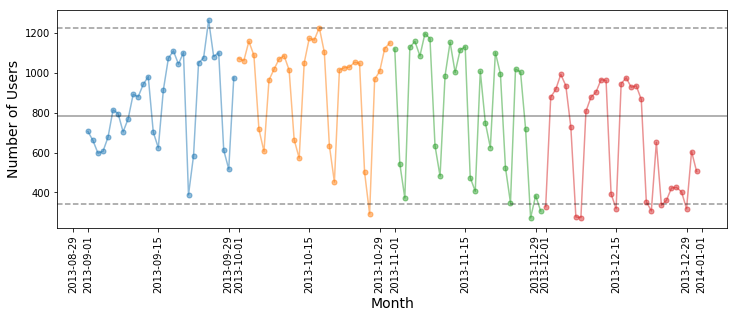

In [64]:
def plot_daily_user_count(n):
    mth = trips[trips['month'] == n]
    mth_cnt = mth.groupby('date').count()['count']
    mth_cnt.plot(marker='o', markersize=5, alpha=.5, rot=90)
    
fig = plt.figure(figsize=(12, 4))
for i in range(9,13):
    plot_daily_user_count(i)
plt.ylabel('Number of Users', fontsize=14)
plt.xlabel('Month', fontsize=14)
count_on_each_day = trips.groupby('date').count()['count']
mean_activity = count_on_each_day.mean()
upper_std = mean_activity + 1.5 * np.std(count_on_each_day)
lower_std = mean_activity - 1.5 * np.std(count_on_each_day)
plt.axhline(upper_std, linestyle='--', c='black', alpha=.4)
plt.axhline(lower_std, linestyle='--', c='black', alpha=.4)
plt.axhline(mean_activity, c='black', alpha=.4)
plt.show()

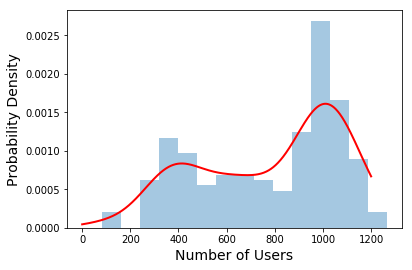

In [68]:
# Plotting the KDE of weekday and weekend combined
x = np.linspace(0, 1200, 1000)
kde_pdf = gaussian_kde(count_on_each_day)
y = kde_pdf(x)
plt.plot(x, y, c='r', lw=2)
count_on_each_day = trips.groupby('date').count()['count']
plt.hist(count_on_each_day, density=1, bins=15, edgecolor='none', alpha=.4)
plt.ylabel('Probability Density', fontsize=14)
plt.xlabel('Number of Users', fontsize=14)
plt.show()

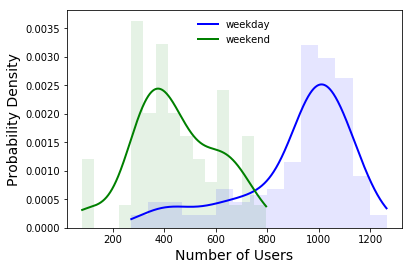

In [69]:
cnt = trips.groupby(['date', 'dayofweek']).count()['count'].reset_index()
weekend = cnt[cnt['dayofweek'] > 5]['count'].values
weekday = cnt[cnt['dayofweek'] <= 5]['count'].values
plt.hist(weekend, bins=15, alpha=.1, edgecolor='none', color='g', density=1)
plt.hist(weekday, bins=15, alpha=.1, edgecolor='none', color='b', density=1)

# Plotting the KDE of weekday and weekend
kde_pdf = gaussian_kde(weekday)
x = np.linspace(min(weekday), max(weekday), 1000)
y = kde_pdf(x)
plt.plot(x, y, color='b', lw=2, label='weekday')

kde_pdf = gaussian_kde(weekend)
x = np.linspace(min(weekend), max(weekend), 1000)
y = kde_pdf(x)
plt.plot(x, y, color='g', lw=2, label='weekend')
plt.ylabel('Probability Density', fontsize=14)
plt.xlabel('Number of Users', fontsize=14)

plt.legend(frameon=False)
plt.show()


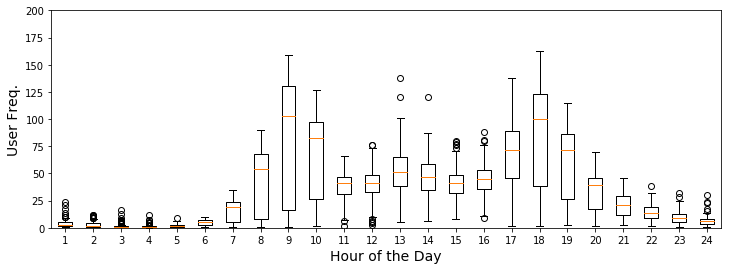

In [78]:
def plot_basic_trends(df):
    fig = plt.figure(figsize=(12, 4))
    start_time = df['start_date']
    hr = start_time.apply(lambda x: x.hour) + 1
    date = start_time.apply(lambda x: x.date())    
    dayofweek = start_time.apply(lambda x: x.dayofweek + 1) # Monday=1, Sunday=7
    df['hr'] = hr
    df['date'] = date
    df['dayofweek'] = dayofweek
    df['count'] = 1

    hr_cnt = df.groupby(['date', 'hr']).count()['count'].reset_index()
    grouped = hr_cnt.groupby('hr')
    lst = [grouped.get_group(hr)['count'] for hr in grouped.groups]
    plt.boxplot(lst)
    plt.ylim(0, 200)
    plt.xlabel('Hour of the Day', fontsize=14)
    plt.ylabel('User Freq.', fontsize=14)

plot_basic_trends(trips)
plt.show()

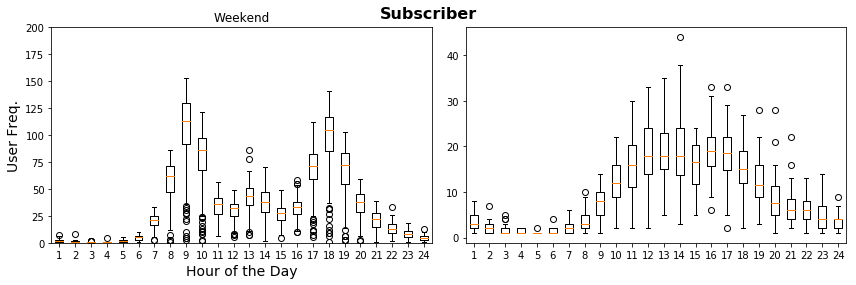

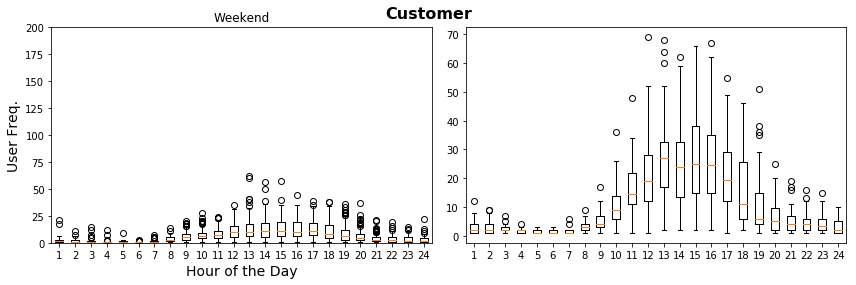

In [82]:
def set_axis_options(ax, title):
    ax.set_ylim(0, 200)
    ax.set_xlabel('Hour of the Day', fontsize=14)
    ax.set_ylabel('User Freq.', fontsize=14)
    ax.set_title(title)

def plot_trends2(df, customer_type):
    df = df[df['subscription_type'] == customer_type] # Customer

    wkday_df = df[df['dayofweek'] <= 5]
    wkend_df = df[df['dayofweek'] > 5]

    wkday_date_hr_cnt = wkday_df.groupby(['date', 'hr']).count()['count'].reset_index()
    wkend_date_hr_cnt = wkend_df.groupby(['date', 'hr']).count()['count'].reset_index()

    wkday_gpby = wkday_date_hr_cnt.groupby('hr')
    wkend_gpby = wkend_date_hr_cnt.groupby('hr')

    wkday_lst = [wkday_gpby.get_group(hr)['count'] for hr in wkday_gpby.groups]
    wkend_lst = [wkend_gpby.get_group(hr)['count'] for hr in wkend_gpby.groups]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.boxplot(wkday_lst)
    ax2.boxplot(wkend_lst)
    set_axis_options(ax1, 'Weekday')
    set_axis_options(ax1, 'Weekend')
    plt.suptitle(customer_type, fontsize=16, fontweight='bold')
    plt.tight_layout()

plot_trends2(trips, 'Subscriber')
plot_trends2(trips, 'Customer')
plt.show()